In [10]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

pd.options.mode.chained_assignment = None

In [11]:
file_name = 'pre_processado_completo.csv'

df = pd.read_csv(file_name, header=0, error_bad_lines=False, warn_bad_lines=False, low_memory=False)

In [12]:
df.head()

,city,state,country,shape,duration_m,comments,latitude,longitude,date
0,san marcos,tx,us,cylinder,45.000000,This event took place in early fall around 194...,29.883056,-97.941111,1949-10-10
1,chester (uk/england),NaN,gb,circle,0.333333,Green/Orange circular disc over Chester&#44 En...,53.200000,-2.916667,1955-10-10
2,edna,tx,us,circle,0.333333,My older brother and twin sister were leaving ...,28.978333,-96.645833,1956-10-10
3,kaneohe,hi,us,light,15.000000,AS a Marine 1st Lt. flying an FJ4B fighter/att...,21.418056,-157.803611,1960-10-10
4,bristol,tn,us,sphere,5.000000,My father is now 89 my brother 52 the girl wit...,36.595000,-82.188889,1961-10-10


In [13]:
# define um array com as latitudes e longitudes

lat_lon = np.array(df[['longitude', 'latitude']]).astype(float)
print(len(lat_lon))
print(lat_lon)

85795
[[-97.9411111  29.8830556]
 [ -2.916667   53.2      ]
 [-96.6458333  28.9783333]
 ...
 [-74.163755   40.858433 ]
 [ 22.891814   50.465843 ]
 [-77.710548   34.367594 ]]


### Analise por país

In [14]:
# define uma lista com os países, e calcula o peso de cada país de acordo com a quantidade de avistamentos, pelo método count

countrys = list(df['country'])
pesos = [countrys.count(c) for c in countrys]

In [15]:
scaler = MinMaxScaler()

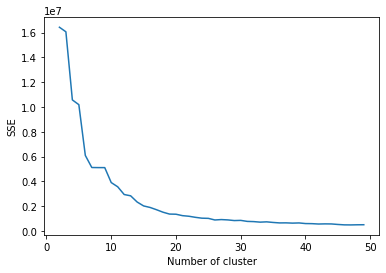

In [16]:
# aplica o elbow criteria

sse = {}
for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(scaler.fit_transform(lat_lon), sample_weight=pesos)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

### Visto que o range para o Elbow Criteria foi grande, o número adequado de clusters está entre 5 e 22
#### A soma dos erros quadráticos não apresenta decaimento significante a partir desses valores, logo o gasto computacional para k_clusters maiores não se torna viável

### Para definir o melhor valor nesse range, foi utilizado o Coeficiente de Silhouette
#### quanto maior o coeficiente, menor a distância intracluster e maior a distância intercluster

In [17]:
# aplica o coeficiente de silhouette

for k in range(5, 22):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(scaler.fit_transform(lat_lon), sample_weight=pesos)
    label = kmeans.labels_
    sil_coeff = metrics.silhouette_score(scaler.fit_transform(lat_lon), label, metric='euclidean')
    print("Para n_clusters={}, o coeficiente de  Silhouette {}".format(k, sil_coeff))

Para n_clusters=5, o coeficiente de  Silhouette 0.4722361671969339
Para n_clusters=6, o coeficiente de  Silhouette 0.5341769531782743
Para n_clusters=7, o coeficiente de  Silhouette 0.457182384394584
Para n_clusters=8, o coeficiente de  Silhouette 0.46839060786422787
Para n_clusters=9, o coeficiente de  Silhouette 0.4651729785328848
Para n_clusters=10, o coeficiente de  Silhouette 0.47668989424179037
Para n_clusters=11, o coeficiente de  Silhouette 0.5037811541216154
Para n_clusters=12, o coeficiente de  Silhouette 0.4673916602578292
Para n_clusters=13, o coeficiente de  Silhouette 0.47641176415956193
Para n_clusters=14, o coeficiente de  Silhouette 0.4385258315852155
Para n_clusters=15, o coeficiente de  Silhouette 0.44685699091571085
Para n_clusters=16, o coeficiente de  Silhouette 0.4806171882601351
Para n_clusters=17, o coeficiente de  Silhouette 0.48287011984834227
Para n_clusters=18, o coeficiente de  Silhouette 0.48102400823889874
Para n_clusters=19, o coeficiente de  Silhouette

### De acordo com o Coeficiente de Silhouette o número adequado de clusters é em torno de 6

In [28]:
# aplica o algoritmo kmeans, utilizando os pesos e normalizando os valores

kmeans = KMeans(n_clusters=6, max_iter=2000)
kmeans.fit(scaler.fit_transform(lat_lon), sample_weight=pesos)
lat_lon_scaled = np.array(scaler.fit_transform(lat_lon))
lat_lon_scaled

array([[0.22167546, 0.64053565],
       [0.4892746 , 0.83629017],
       [0.2253231 , 0.63294017],
       ...,
       [0.28863507, 0.73267807],
       [0.56195408, 0.81333589],
       [0.27864692, 0.67818504]])

In [30]:
centers = kmeans.cluster_centers_
centers

array([[0.1557812 , 0.78487001],
       [0.25180196, 0.65704072],
       [0.89296389, 0.1251887 ],
       [0.49491641, 0.83022343],
       [0.26736873, 0.73459503],
       [0.16990151, 0.68888293]])

In [31]:
locations = kmeans.labels_.astype(float)
print(len(locations))
locations

85795


array([1., 3., 1., ..., 4., 3., 1.])

Text(0, 0.5, 'Longitude')

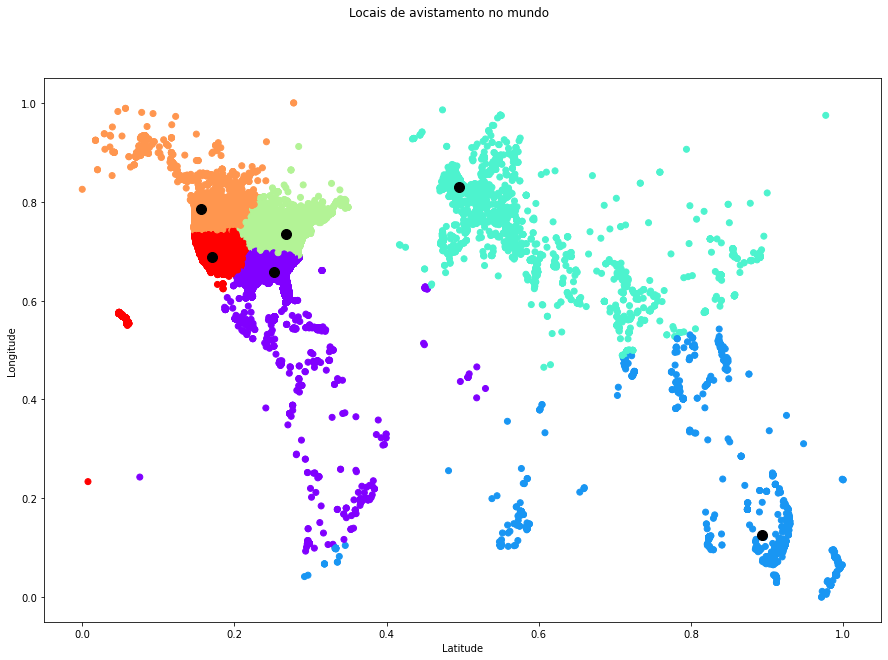

In [22]:
fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(lat_lon_scaled[:, 0], lat_lon_scaled[:, 1], c=locations, cmap='rainbow')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=100)
fig.suptitle('Locais de avistamento no mundo')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

Text(0, 0.5, 'Longitude')

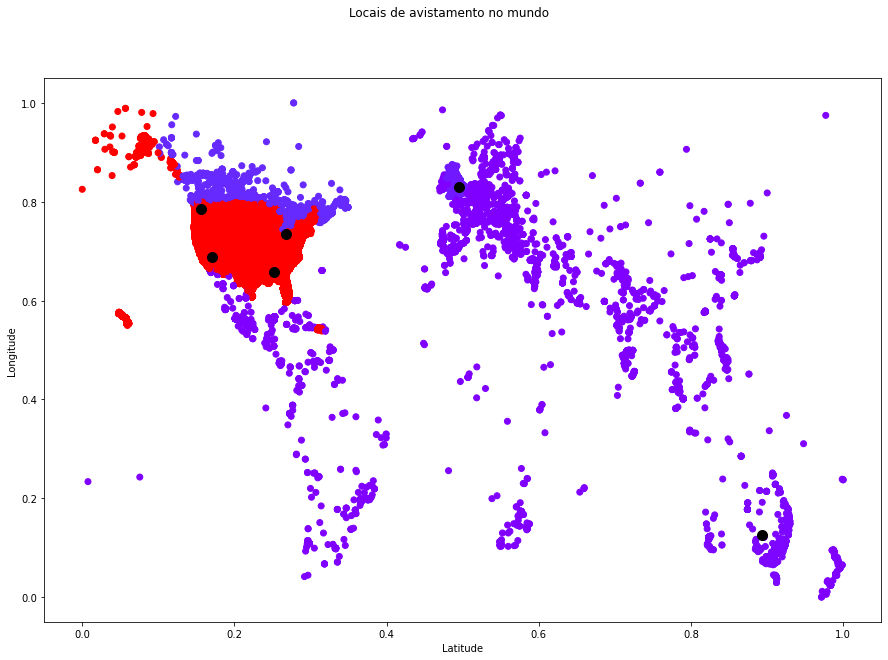

In [23]:
fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(lat_lon_scaled[:, 0], lat_lon_scaled[:, 1], c=pesos, cmap='rainbow')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=100)
fig.suptitle('Locais de avistamento no mundo')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

In [24]:
geolocator = Nominatim(user_agent="geoapiExercises")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [32]:
centers_notscaled = scaler.inverse_transform(centers)
centers_notscaled = centers_notscaled.tolist()

for i in range(len(centers_notscaled)):
    centers_notscaled[i][0], centers_notscaled[i][1] = centers_notscaled[i][1], centers_notscaled[i][0]

centers_notscaled = [tuple(center) for center in centers_notscaled]
centers_notscaled

[(47.07518154821622, -121.3401599310602),
 (31.849027734022396, -87.2431896728704),
 (-31.50156227268545, 140.43338211965434),
 (52.477372211828964, -0.91325884385739),
 (41.08676763404937, -81.71543118449455),
 (35.64185370271266, -116.32603615298724)]

In [33]:
address = [reverse(loc) for loc in centers_notscaled]

In [34]:
centers_countrys = []
for i in range(len(centers_notscaled)):
    try:
        centers_countrys.append(address[i].raw['address']['country'])
    except:
        centers_countrys.append('NULL')
centers_countrys

['United States',
 'United States',
 'Australia',
 'United Kingdom',
 'United States',
 'United States']

In [35]:
locations = list(locations)
locations = [int(item) for item in locations]
centers_countrys_all = [centers_countrys[loc] for loc in locations]
centers_countrys_all

['United States',
 'United Kingdom',
 'United States',
 'United States',
 'United States',
 'United Kingdom',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United Kingdom',
 'United States',
 'United States',
 'United States',
 'United Kingdom',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United Kingdom',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'United States',
 'Uni

In [36]:
pd.set_option("max_colwidth", 120)
df['pesos'] = pesos
df['k-countrys'] = centers_countrys_all
df['k-centers'] = locations
df[['country', 'pesos', 'k-countrys', 'k-centers']].head(15)

,country,pesos,k-countrys,k-centers
0,us,75981,United States,1
1,gb,2524,United Kingdom,3
2,us,75981,United States,1
3,us,75981,United States,5
4,us,75981,United States,4
5,gb,2524,United Kingdom,3
6,us,75981,United States,4
7,us,75981,United States,1
8,us,75981,United States,1
9,us,75981,United States,5
